<a href="https://colab.research.google.com/github/gforconi/UTNIA2025/blob/main/TP_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de alumnos

**Ejercicio de Clasificación de Imágenes con Red Neuronal en PyTorch**

Tomando como partida el siguiente notebook, que dispone de un conjunto de imágenes ya recortadas y clasificadas, correspondientes a cada alumno.

**Objetivo:** Crear y entrenar una red neuronal convolucional (CNN) que identifique correctamente al alumno correspondiente a partir de sus imágenes. Evaluar el desempeño del modelo usando diversas métricas y técnicas de visualización. Para esto se deberan apollar del notebook utilizado en clases.

**Información del Dataset:**
- Cada carpeta lleva el nombre del alumno y contiene imágenes del rostro del mismo.
- Las imágenes tienen un tamaño de 224 × 224 píxeles, y al cargarlas se utiliza solamente un canal (escala de grises).
- Las imágenes ya están recortadas a un tamaño uniforme y organizadas adecuadamente para facilitar su carga mediante PyTorch.


# Pasos del Ejercicio:

In [ ]:
import requests
import zipfile
import io
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns


## 1. Preparación de los datos



> **Prestar atencion al archivo que descarguen.**



In [ ]:
# URL del ZIP en GitHub

# Imagenes turno tarde
url = 'https://github.com/gforconi/UTNIA2025/raw/b39824a936e08df1ec3062fc3c63a345f8d1e981/TP-Redes%20Neuronales/TTProcesadasCalsificadas.zip'

# Descargá el ZIP
response = requests.get(url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall("data")  # o el path que quieras
    print("Imágenes descargadas y descomprimidas con éxito.")
else:
    print(f"Error al descargar el ZIP: {response.status_code}")


Imágenes descargadas y descomprimidas con éxito.


In [ ]:
# Transforms: Escalado, gris, tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

path = r'/content/data/ProcesadasCalsificadas'
dataset = datasets.ImageFolder(path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

classes = dataset.classes

Si observan la carpeta `data/ProcesadasClasificadas` veran que dentro hay una carpeta por alumno. Dentro de cada carpeta estan las imagenes tomadas por sus compañeros.

Dividimos el datsets en Train y Test para el entrenamiento y la validación:

In [ ]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 2. Visualización rápida del dataset

In [ ]:
def mostrar_dos_imagenes_por_clase(dataset):
    clases = dataset.classes
    indices_por_clase = {clase: [] for clase in clases}

    # Encontrar los índices de dos imágenes por clase
    for idx, (_, label) in enumerate(dataset.imgs):
        clase = clases[label]
        if len(indices_por_clase[clase]) < 2:
            indices_por_clase[clase].append(idx)
        if all(len(imgs) == 2 for imgs in indices_por_clase.values()):
            break

    fig, axs = plt.subplots(len(clases), 2, figsize=(6, 3 * len(clases)))
    for i, clase in enumerate(clases):
        for j, idx in enumerate(indices_por_clase[clase]):
            imagen, label = dataset[idx]
            if isinstance(imagen, torch.Tensor):
                imagen = imagen.permute(1,2,0)  # Para mostrar imagen de torch (C,H,W) a (H,W,C)
            axs[i, j].imshow(imagen)
            axs[i, j].set_title(f'Clase: {clase}')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


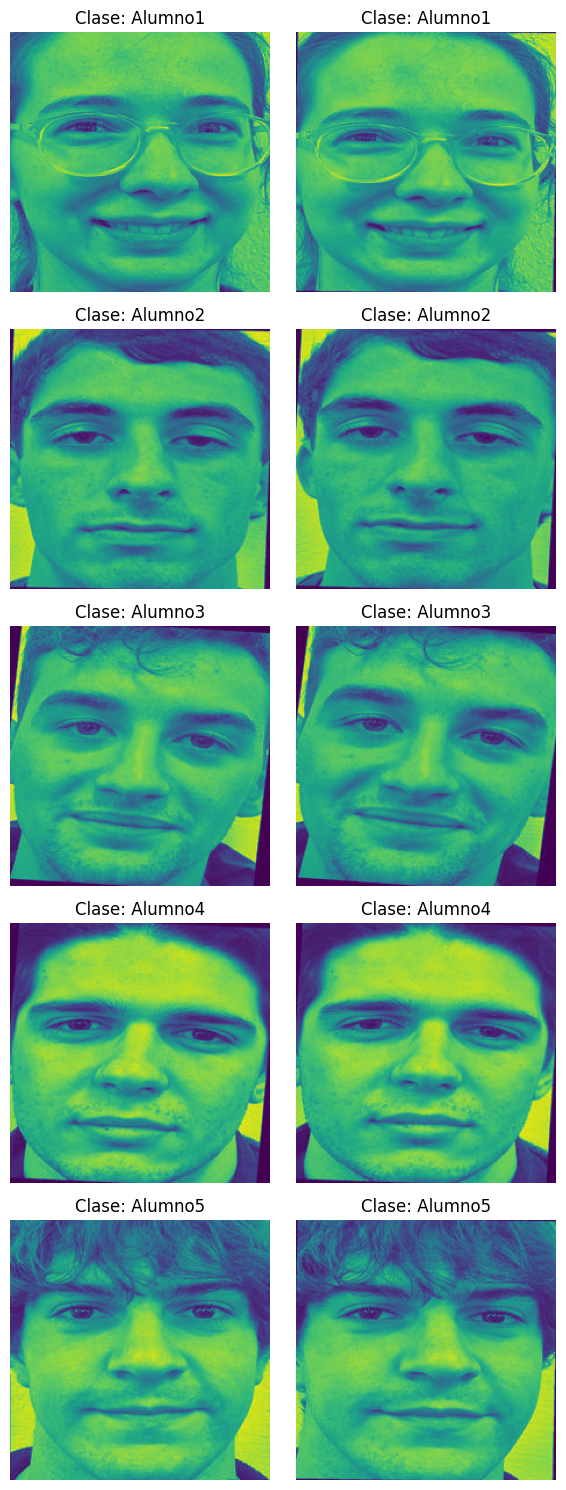

In [ ]:
mostrar_dos_imagenes_por_clase(dataset) # Muestra las imagenes del dataset
# mostrar_dos_imagenes_por_clase(traindataset.dataset) # Muestra las imagenes del conjunto train
# mostrar_dos_imagenes_por_clase(testdataset.dataset) # Muestra las imagenes del conjunto test

## 3. Definición del modelo

Define una arquitectura básica de CNN con capas convolucionales, funciones de activación ReLU, capas de pooling, y capas completamente conectadas.

Decide la cantidad de neuronas y capas según consideres adecuado inicialmente.

Para esta etapa podran ayudarse de la estructura definida en el notebook de clase ([link al notebook](https://https://github.com/gforconi/UTNIA2025/blob/486178b72dd2ad6b8ebb3c304e3c1669f1a1c00b/Clasificador_de_im%C3%A1genes.ipynb))

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 4. Función de entrenamiento y validación (con registro de métricas)

Escribe funciones que entrenen el modelo durante un número determinado de épocas.

Registra la pérdida (loss) y la precisión (accuracy) tanto para el conjunto de entrenamiento como para el de validación en cada época.

In [ ]:
def train_and_validate(optimizer_name, num_epochs=10):
    print(f"\n===> Entrenando con {optimizer_name}...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = Net(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=0.001)
    else:
        raise ValueError("Solo se permite Adam o RMSprop.")

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        # --- Entrenamiento ---
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validación ---
        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = val_loss / total
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = net.state_dict()

        print(f"Época {epoch+1}: Train loss={train_loss:.4f}, Train acc={train_acc:.2f}%, Val loss={val_loss:.4f}, Val acc={val_acc:.2f}%")

    net.load_state_dict(best_model_wts)
    return train_losses, train_accuracies, val_losses, val_accuracies, net



## 5. Entrenamiento

Realiza el entrenamiento de la CNN usando la función definida.

Experimenta con diferentes valores iniciales de hiperparámetros como la tasa de aprendizaje, número de épocas o batch size según veas la necesidad.

Mencionar todas las opciones evaluadas.

In [ ]:
adam_hist = train_and_validate('Adam', num_epochs=10)
rmsprop_hist = train_and_validate('RMSprop', num_epochs=10)


===> Entrenando con Adam...
Época 1: Train loss=1.7013, Train acc=15.79%, Val loss=1.5864, Val acc=20.51%
Época 2: Train loss=1.5544, Train acc=46.05%, Val loss=1.6296, Val acc=10.26%
Época 3: Train loss=1.4388, Train acc=50.66%, Val loss=1.3627, Val acc=66.67%
Época 4: Train loss=1.2288, Train acc=59.21%, Val loss=0.9910, Val acc=71.79%
Época 5: Train loss=0.8916, Train acc=65.13%, Val loss=1.1101, Val acc=48.72%
Época 6: Train loss=0.7038, Train acc=65.79%, Val loss=0.8994, Val acc=69.23%
Época 7: Train loss=0.5597, Train acc=80.92%, Val loss=0.4064, Val acc=82.05%
Época 8: Train loss=0.2799, Train acc=92.11%, Val loss=0.2820, Val acc=89.74%
Época 9: Train loss=0.1267, Train acc=97.37%, Val loss=0.0875, Val acc=97.44%
Época 10: Train loss=0.0662, Train acc=98.03%, Val loss=0.1200, Val acc=97.44%

===> Entrenando con RMSprop...
Época 1: Train loss=6.6043, Train acc=23.68%, Val loss=1.5930, Val acc=17.95%
Época 2: Train loss=1.5811, Train acc=29.61%, Val loss=1.5411, Val acc=38.46%
Ép

## 6. Gráficas de métricas (Loss y Accuracy)

Genera gráficos que muestren la evolución de la pérdida y precisión durante el entrenamiento y validación.


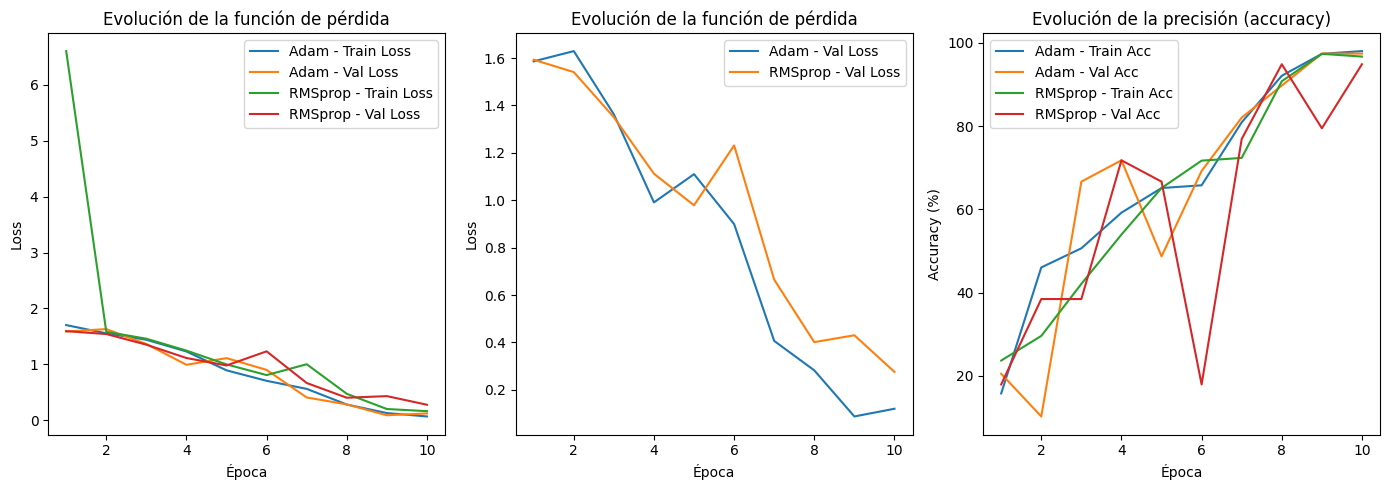

In [ ]:
# Número de épocas según entrenamiento
epochs = range(1, len(adam_hist[0]) + 1)


plt.figure(figsize=(14, 5))


# Gráfica de pérdidas (loss)
plt.subplot(1, 3, 1)
plt.plot(epochs, adam_hist[0], label='Adam - Train Loss')
plt.plot(epochs, adam_hist[2], label='Adam - Val Loss')
plt.plot(epochs, rmsprop_hist[0], label='RMSprop - Train Loss')
plt.plot(epochs, rmsprop_hist[2], label='RMSprop - Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolución de la función de pérdida')
plt.legend()


# Gráfica de pérdidas (loss) sin train
plt.subplot(1, 3, 2)
plt.plot(epochs, adam_hist[2], label='Adam - Val Loss')
plt.plot(epochs, rmsprop_hist[2], label='RMSprop - Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolución de la función de pérdida')
plt.legend()


# Gráfica de precisión (accuracy)
plt.subplot(1, 3, 3)
plt.plot(epochs, adam_hist[1], label='Adam - Train Acc')
plt.plot(epochs, adam_hist[3], label='Adam - Val Acc')
plt.plot(epochs, rmsprop_hist[1], label='RMSprop - Train Acc')
plt.plot(epochs, rmsprop_hist[3], label='RMSprop - Val Acc')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.title('Evolución de la precisión (accuracy)')
plt.legend()


plt.tight_layout()
plt.show()



## 7. Interpretación de las gráficas de entrenamiento y validación

Analiza las gráficas obtenidas. ¿Hay indicios de sobreajuste o subajuste?

¿Qué podrías modificar para mejorar el desempeño del modelo?

In [ ]:
"""Evolución de la función de pérdida (Loss)

RMSprop presenta una caída inicial muy marcada de la loss de entrenamiento, pero la validación (rojo) fluctúa bastante
, lo que sugiere que el modelo no generaliza de forma tan estable.

Adam tiene un descenso más progresivo y consistente en ambas curvas (train y val),
 mostrando aprendizaje más controlado y validación más estable.

En loss de validación (líneas naranja y roja),ambas son bastnte consistentes con algunos picos.
Lo cual indica que sus predicciones en datos no vistos son considerablemente consistentes, pero el modelo podría estar sufriendo
cierta inestabilidad o sobreajuste y que no lo podamos ver por la escala (quitar RSM train para poder comparar las otras mejor).
()

Si bien ambas losses de validación bajan al principio, la de RMSprop presenta mayores picos  , lo cual suele indicar
que el modelo tiene más dificultad para generalizar fuera del set de entrenamiento.

Evolución de la precisión (Accuracy)

Tanto Adam como RMSprop muestran un incremento claro de accuracy de entrenamiento (líneas azul y verde), alcanzando valores cercanos
 al 90% al final de las 10 épocas. Pero presentan grandes picos.

 En loss de validación (líneas naranja y roja), luego de la 8 época es más baja que la de RMSprop.

 RMSprop sube rápido pero con más variaciones entre épocas, en entrenamiento y Adam tiene menos variacion.

Conclusión

No hay sobreajuste fuerte, porque las curvas de validación acompañan a las de entrenamiento, aunque parse ser una epoca atrasada.

RMSprop aprende más rápido al inicio pero es más inestable.

Adam es más confiable y consistente en validación, por lo que sería la opción recomendada.
"""

'Evolución de la función de pérdida (Loss)\n\nRMSprop presenta una caída inicial muy marcada de la loss de entrenamiento, pero la validación (rojo) fluctúa bastante\n, lo que sugiere que el modelo no generaliza de forma tan estable.\n\nAdam tiene un descenso más progresivo y consistente en ambas curvas (train y val),\n mostrando aprendizaje más controlado y validación más estable.\n\nEn loss de validación (líneas naranja y roja),ambas son bastnte consistentes con algunos picos. \nLo cual indica que sus predicciones en datos no vistos son considerablemente consistentes, pero el modelo podría estar sufriendo\ncierta inestabilidad o sobreajuste y que no lo podamos ver por la escala (quitar RSM train para poder ccomparar las otras mejor).\n\nSi bien ambas losses de validación bajan al principio, la de RMSprop presenta mayores picos  , lo cual suele indicar \nque el modelo tiene más dificultad para generalizar fuera del set de entrenamiento.\n\nEvolución de la precisión (Accuracy)\n\nTanto 

## 8. F1-score y Matriz de Confusión

- Calcula el F1-score y genera una matriz de confusión usando el conjunto de prueba.
- Analiza qué alumnos son más difíciles de clasificar.

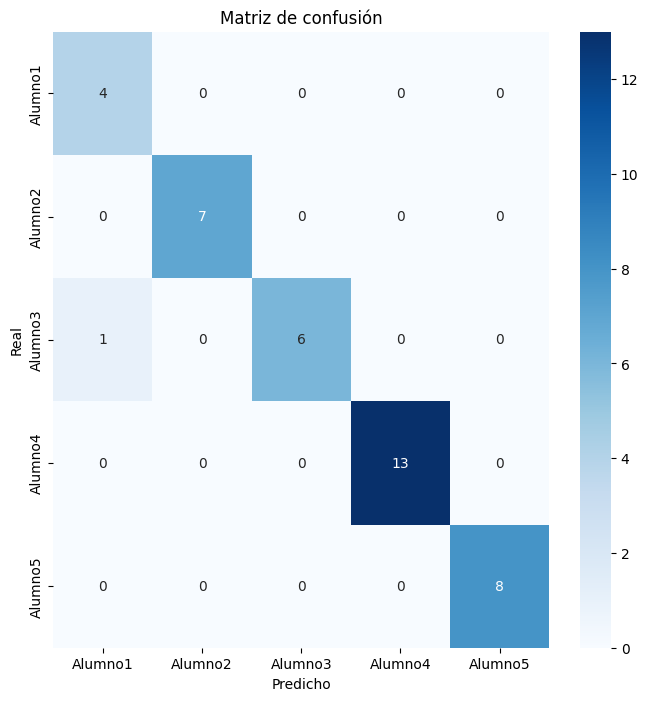

              precision    recall  f1-score   support

     Alumno1       0.80      1.00      0.89         4
     Alumno2       1.00      1.00      1.00         7
     Alumno3       1.00      0.86      0.92         7
     Alumno4       1.00      1.00      1.00        13
     Alumno5       1.00      1.00      1.00         8

    accuracy                           0.97        39
   macro avg       0.96      0.97      0.96        39
weighted avg       0.98      0.97      0.97        39



In [ ]:
# Usamos el mejor modelo Adam para calcular métricas avanzadas
model = adam_hist[4]
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcula matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Muestra matriz de confusión en gráfico
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

# Muestra reporte de métricas incluyendo F1-score
print(classification_report(all_labels, all_preds, target_names=classes))



# **Preguntas finales:**

- ¿Cuál es el alumno con mayor error de clasificación? ¿A qué crees que se debe este error?
- ¿Tuviste que modificar algún hiperparámetro durante el entrenamiento? ¿Cuáles fueron y qué efecto tuvieron?